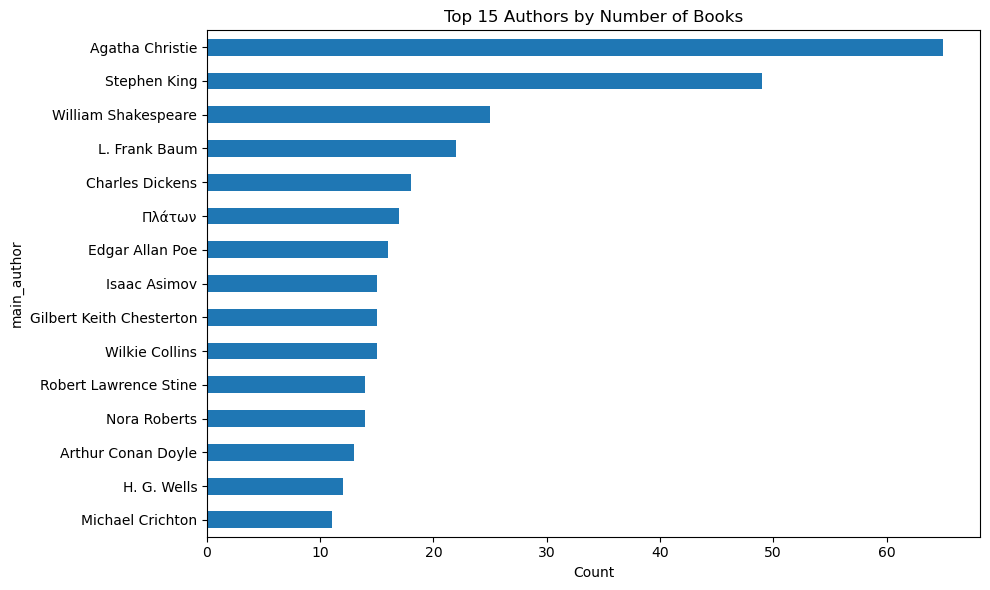

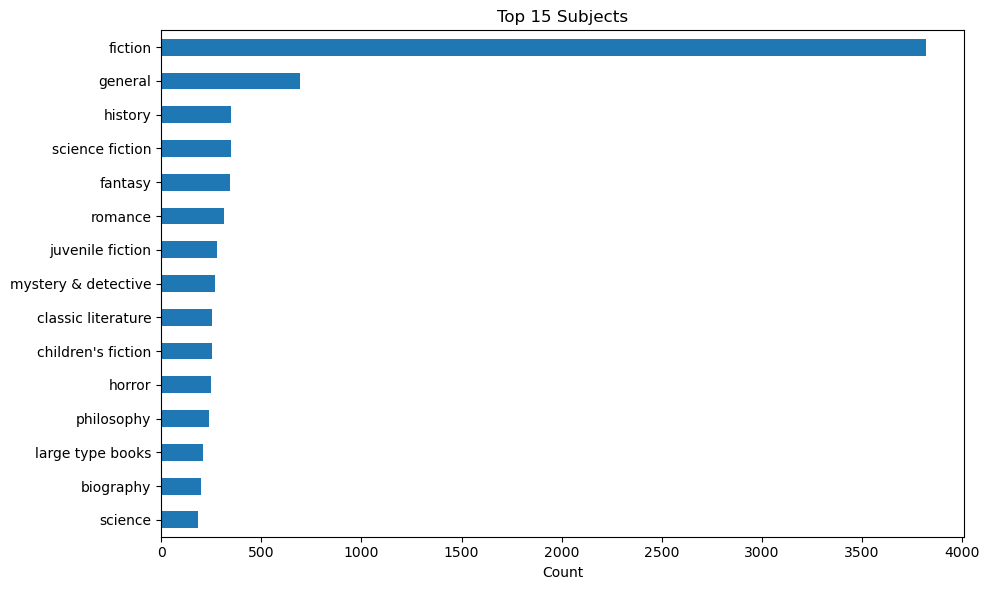

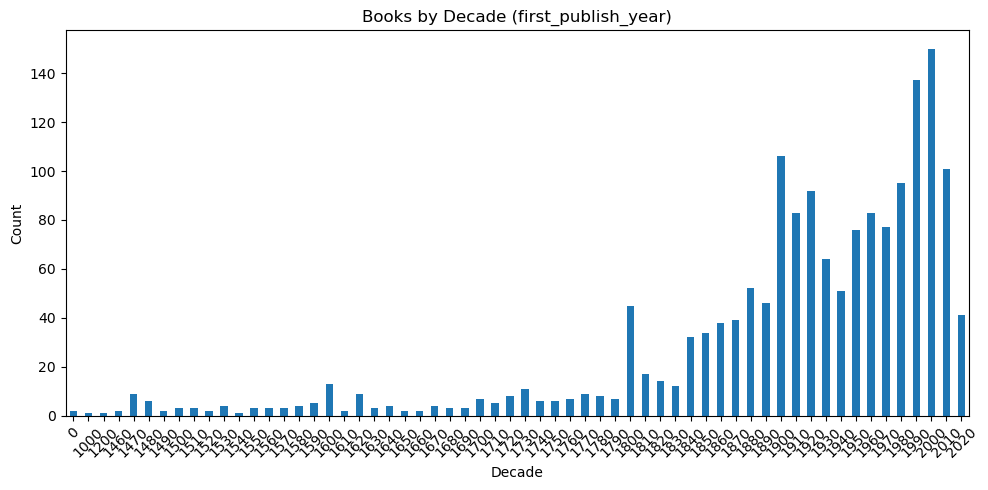

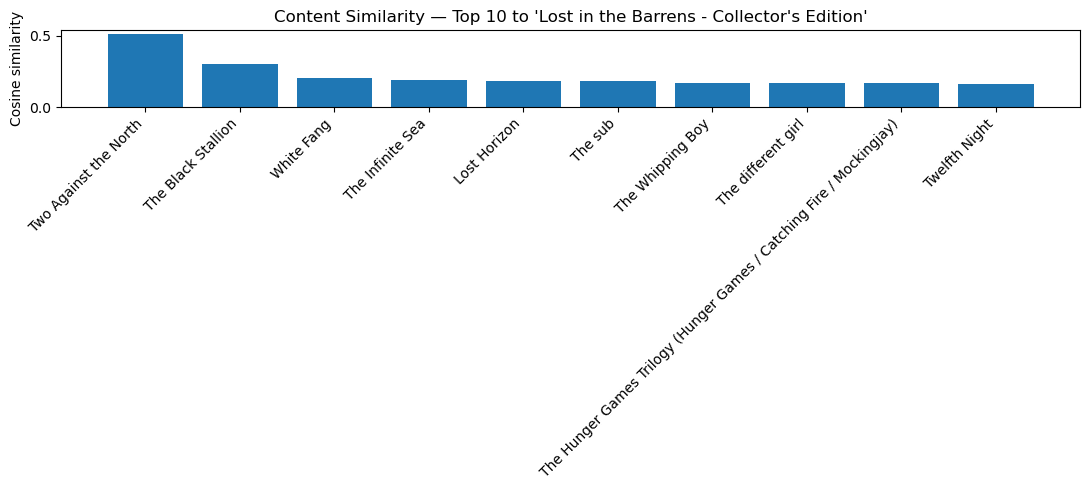

In [2]:
import os, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix


df = pd.read_csv("../data/clean_openlibrary_books.csv")

#Top Authors
author_counts = df["main_author"].fillna("Unknown").value_counts().head(15)
plt.figure(figsize=(10,6))
author_counts.iloc[::-1].plot(kind="barh")
plt.title("Top 15 Authors by Number of Books")
plt.xlabel("Count")
plt.tight_layout()
plt.savefig("viz_top_authors.png")
plt.show()

#Top Subjects
def tokenize_subjects(s):
    if pd.isna(s): 
        return []
    toks = [t.strip().lower() for t in str(s).split(",")]
    toks = [t for t in toks if len(t) > 2]
    return toks

subj_counter = Counter()
for s in df["subjects"].dropna():
    for tok in tokenize_subjects(s):
        subj_counter[tok] += 1

top_subjects = pd.Series(dict(subj_counter.most_common(15)))
plt.figure(figsize=(10,6))
top_subjects.iloc[::-1].plot(kind="barh")
plt.title("Top 15 Subjects")
plt.xlabel("Count")
plt.tight_layout()
plt.savefig("viz_top_subjects.png")
plt.show()

#3Publication Years by Decade
years = pd.to_numeric(df["first_publish_year"], errors="coerce").dropna().astype(int)
if not years.empty:
    decades = (years // 10) * 10
    decade_counts = decades.value_counts().sort_index()
    plt.figure(figsize=(10,5))
    decade_counts.plot(kind="bar")
    plt.title("Books by Decade (first_publish_year)")
    plt.ylabel("Count")
    plt.xlabel("Decade")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("viz_years_decade.png")
    plt.show()

#4) Content-based similarity
df["text"] = (
    df["title"].fillna("") + " " +
    df["main_author"].fillna("") + " " +
    df["subjects"].fillna("")
)
tfidf = TfidfVectorizer(stop_words="english", min_df=2)
X = tfidf.fit_transform(df["text"])

title_to_idx = {t.lower(): i for i, t in enumerate(df["title"].astype(str))}
sample_title = df.sample(1, random_state=7)["title"].iloc[0]
idx = title_to_idx[sample_title.lower()]
sims = cosine_similarity(X[idx], X).ravel()
order = sims.argsort()[::-1]
topk = [j for j in order if j != idx][:10]
labels = df.iloc[topk]["title"].tolist()
scores = sims[topk]

plt.figure(figsize=(11,5))
plt.bar(range(len(topk)), scores)
plt.xticks(range(len(topk)), labels, rotation=45, ha="right")
plt.title(f"Content Similarity — Top 10 to '{sample_title}'")
plt.ylabel("Cosine similarity")
plt.tight_layout()
plt.savefig("viz_content_similar.png")
plt.show()